In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

import torchvision.transforms as transforms
from torchvision.models import vgg16

c:\Users\Seb\anaconda3\envs\gpu_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Le but de ce notebook est de visualiser et comprendre la prédiction d'un CNN, ici VGG16.  
#### Pour cela différentes images seront présentées au modèle, celui-ci effectuera une prédiction pour chacune.  En récupérant ces prédictions, on est en mesure de calculer les gradients associés à chaque image.  Ceux-ci nous permettront de visualiser les zones d'intérêt de chaque image (pour le modèle).

On charge ici trois images de lion qui seront présentés au modèle.

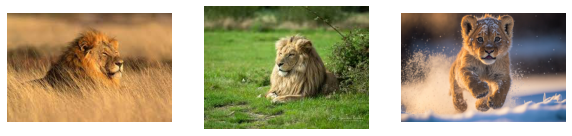

In [2]:
image_path = r"C:\Users\Seb\OneDrive\Documents\Code_Python\img\lions"
image_files = ['lion1.jpg', 'lion2.jpg', 'lion3.jpg']
list_image = []

plt.figure(figsize=(10, 8))
for i, file in enumerate(image_files):
    path = os.path.join(image_path, file)
    image = Image.open(path)
    list_image.append(image)
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.axis('off')

On défini une transformation pour chaque image.  
Celle-ci comprend un redimmensionnement, un passage sous forme de tenseur et une normalisation.  
Finalement, on obtient un batch de 3 images.

In [3]:
# Define your transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image
    transforms.ToTensor(),           # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the image
])

images_tensor = torch.zeros((3, 3, 256, 256))
for i, image in enumerate(list_image):
    # Apply transformations
    images_tensor[i, ...] = transform(image)
    
images_tensor.size()

torch.Size([3, 3, 256, 256])

## Définition du modèle

On défini notre modèle *VGG* se basant sur *vgg16*. Pour cela, on charge le modèle pré-entraîné. Ensuite, la partie convolutive est séparée de la partie classification, sous la forme:  
- *self.feature_conv* -> partie convolutive ;
- *self.classifier* -> partie classification ;

On défini également l'attribut gradient dont on se servira plus tard.

In [4]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        # charge le modèle pré-entrainé vgg16
        self.vgg = vgg16(pretrained=True)
        # init de la partie convolutive
        self.features_conv = self.vgg.features[:30]
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.flatten = nn.Flatten()
        # init de la partie classifier de vgg19
        self.classifier = self.vgg.classifier
        # init des gradients
        self.gradients = None
    
    def activations_hook(self, grad):
        """Hook pour les gradients des activations"""
        self.gradients = grad
        
    def forward(self, x):
        """Méthode de propagation de l'entrée au travers du réseau"""
        x = self.features_conv(x)
        # Enregistrer la fonction hook sur le gradient de x
        x.register_hook(self.activations_hook)
        x = self.classifier(self.flatten(self.avgpool(x)))
        return x
    
    def get_activations_gradient(self):
        """Méthode pour extraction de gradient"""
        return self.gradients
    
    def get_activations(self, x):
        """Méthode pour extraction après fonction d'activation"""
        return self.features_conv(x)

In [5]:
def get_superposed_image(heatmap):
    """A partir de la heatmap et de l'image originale
       retourne la superposition de l'image et de la heamap
    """
    img = cv2.imread(os.path.join(r".\img\lions", f"lion{i+1}.jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    return heatmap * 0.4 + img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


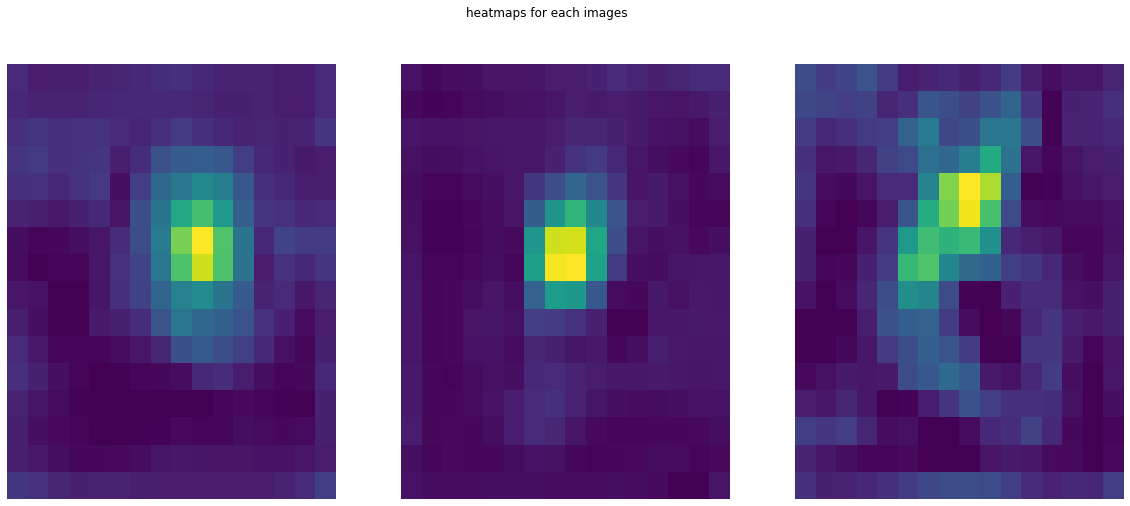

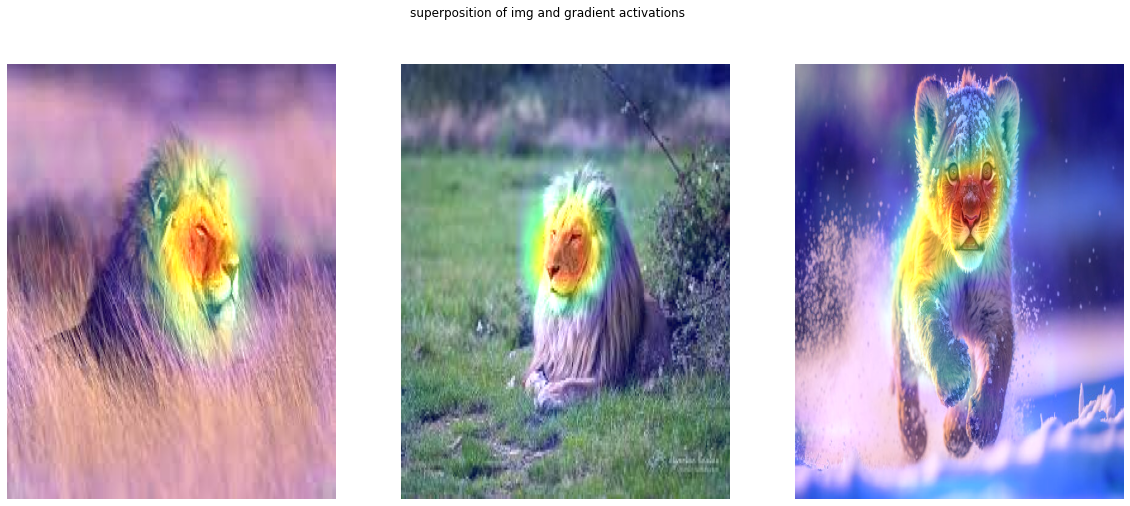

In [6]:
# init VGG
vgg = VGG()
# vgg en mode eval
vgg.eval()

fig1, axes1 = plt.subplots(1, 3, figsize=(20, 8))
fig2, axes2 = plt.subplots(1, 3, figsize=(20, 8)) 
fig1.suptitle('heatmaps for each images')
fig2.suptitle('superposition of img and gradient activations')

for i in range(images_tensor.size(0)):
    # recupération des prédictions
    pred = vgg(images_tensor[i].unsqueeze(0))

    # la classe lion est la 291
    pred[:, 291].backward()

    # récupération des gradients 
    gradients = vgg.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # récupération des activations et associations aux gradients
    activations = vgg.get_activations(images_tensor[i, ...].unsqueeze(0)).detach()
    for k in range(512):
        activations[:, k, :, :] *= pooled_gradients[k]
    
    # creation heatmap
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)

    # creation de l'image superposée
    superimposed_img = get_superposed_image(heatmap)

    axes1[i].imshow(heatmap.squeeze(), aspect='auto')
    axes1[i].axis('off')

    axes2[i].imshow(superimposed_img.astype(int), aspect='auto')
    axes2[i].axis('off')

plt.show()

# Conclusion: Les prédictions de VGG16 sont bien évidemment faites en se basant sur ce qui est important dans l'image est non sur l'arrière plan par exemple.